In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from imblearn.over_sampling import SMOTE

In [10]:
reviews_df = pd.read_json("mini-appliances.jsonl", lines=True)
print(reviews_df.head())

   rating                                      title  \
0       1                     Don’t waste your money   
1       3  Does the job in an extremely loud fashion   
2       3              Leaks but company did replace   
3       5                       Good Quality & Handy   
4       5                                 Five Stars   

                                                text  \
0  Got mold on the filter with a weeks worth of u...   
1  The ice machine makes the ice so quickly. But,...   
2  UPDATE :  Contacted company directly since I w...   
3  This frothing pitcher is the perfect size, eas...   
4                        Great OEM and high quality.   

                                              images        asin parent_asin  \
0  [{'small_image_url': 'https://images-na.ssl-im...  B003PEBFU2  B003PEBFU2   
1                                                 []  B08FZYMWJT  B07NVJP82G   
2                                                 []  B01FG2VIRA  B0B1CYSYQ1   
3     

In [11]:
# Classify sentiment based on rating
conditions = [
    (reviews_df['rating'] <= 2),
    (reviews_df['rating'] == 3),
    (reviews_df['rating'] >= 4)
]

sentiment = [
    'negative',
    'neutral',
    'positive'
]

reviews_df['sentiment_label'] = np.select(conditions, sentiment, default='unknown')

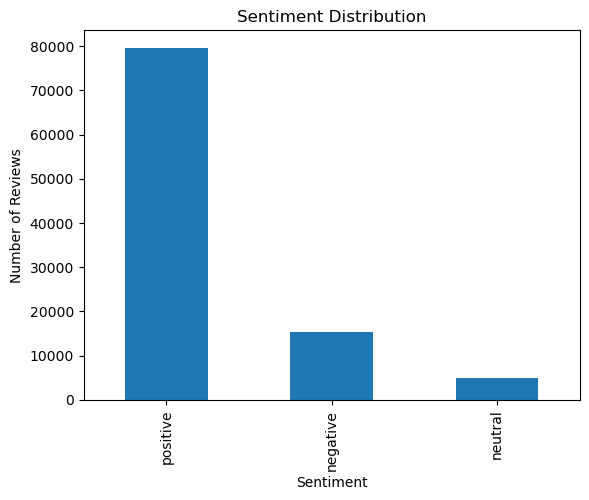

In [12]:
# Visualize sentiment distribution
reviews_df['sentiment_label'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

In [40]:
# Preprocess text 

# Removing stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

reviews_df['title'] = reviews_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
reviews_df['text'] = reviews_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Perform lemmatization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

reviews_df['title'] = reviews_df['title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
reviews_df['text'] = reviews_df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Convert to lowercase and remove punctuation
punctuation_pattern = r'[^a-zA-Z0-9\s]'

reviews_df['title'] = reviews_df['title'].str.lower().replace(punctuation_pattern, '', regex=True)
reviews_df['text'] = reviews_df['text'].str.lower().replace(punctuation_pattern, '', regex=True)

# Combine title and text
reviews_df['cleaned_text'] = reviews_df['title'] + ' ' + reviews_df['text']
print(reviews_df[['cleaned_text', 'sentiment_label']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                        cleaned_text sentiment_label
0  dont waste money got mold filter week worth us...        negative
1  doe job extremely loud fashion ice machine mak...         neutral
2  leak company replace update contacted company ...         neutral
3  good quality handy frothing pitcher perfect si...        positive
4                   five star great oem high quality        positive


In [69]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.0001, max_df=0.8)
X = vectorizer.fit_transform(reviews_df['cleaned_text'])
print(vectorizer.get_feature_names_out()[:20])

y = reviews_df['sentiment_label']

['01' '02' '05' '10' '10 10' '10 12' '10 15' '10 buck' '10 cup' '10 day'
 '10 degree' '10 foot' '10 inch' '10 min' '10 minute' '10 month' '10 oz'
 '10 second' '10 star' '10 time']


In [70]:
print(f"Original Distribution: \n{y.value_counts()}")

# Oversampling using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print(f"\nResampled Distribution: \n{y_res.value_counts()}")

Original Distribution: 
sentiment_label
positive    79606
negative    15424
neutral      4970
Name: count, dtype: int64

Resampled Distribution: 
sentiment_label
negative    79606
neutral     79606
positive    79606
Name: count, dtype: int64


Accuracy: 0.9598861066912319
Classification Report: 
              precision    recall  f1-score   support

    negative       0.95      0.98      0.97     15921
     neutral       0.95      0.99      0.97     15921
    positive       0.99      0.90      0.94     15922

    accuracy                           0.96     47764
   macro avg       0.96      0.96      0.96     47764
weighted avg       0.96      0.96      0.96     47764



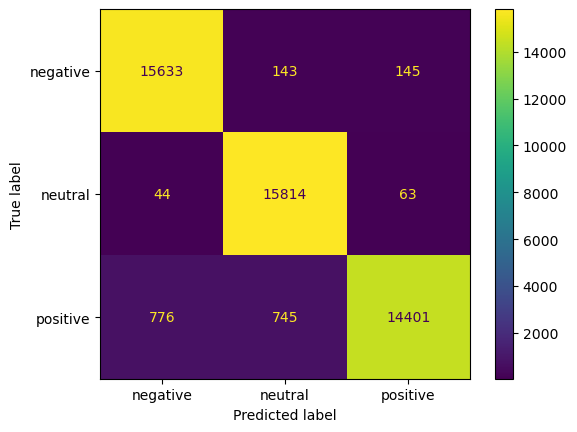

In [71]:
# Split data into training and testing sets
X_trn, X_tst, y_trn, y_tst = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Tune the Naive Bayes classifier with GridSearch
lr = LogisticRegression(class_weight='balanced', max_iter=1000, C=100, solver='liblinear')

lr.fit(X_trn, y_trn)
y_pred = lr.predict(X_tst)

accuracy = np.mean(y_pred == y_tst)

# Display results
print(f"Accuracy: {accuracy}")

print(f"Classification Report: \n{classification_report(y_tst, y_pred)}")

cm = confusion_matrix(y_tst, y_pred, labels=sentiment)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiment)
disp.plot()
plt.show()